# RNN Time Series Forecasting

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import math
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from keras import callbacks
import pickle


Using TensorFlow backend.


In [111]:
PATH = r"../../Data/completeLoad.csv"
df = pd.read_csv(PATH)
df

,zone_id,year,month,day,h1,h2,h3,h4,h5,h6,...,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24
0,1,2004,1,1,16853.0,16450.0,16517.0,16873.0,17064.0,17727.0,...,13518.0,13138.0,14130.0,16809.0,18150.0,18235.0,17925.0,16904.0,16162.0,14750.0
1,1,2004,1,2,14155.0,14038.0,14019.0,14489.0,14920.0,16072.0,...,16127.0,15448.0,15839.0,17727.0,18895.0,18650.0,18443.0,17580.0,16467.0,15258.0
2,1,2004,1,3,14439.0,14272.0,14109.0,14081.0,14775.0,15491.0,...,13507.0,13414.0,13826.0,15825.0,16996.0,16394.0,15406.0,14278.0,13315.0,12424.0
3,1,2004,1,4,11273.0,10415.0,9943.0,9859.0,9881.0,10248.0,...,14207.0,13614.0,14162.0,16237.0,17430.0,17218.0,16633.0,15238.0,13580.0,11727.0
4,1,2004,1,5,10750.0,10321.0,10107.0,10065.0,10419.0,12101.0,...,13845.0,14350.0,15501.0,17307.0,18786.0,19089.0,19192.0,18416.0,17006.0,16018.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32975,20,2008,7,3,76155.0,70965.0,66933.0,65895.0,67642.0,73051.0,...,107043.0,111161.0,114445.0,117268.0,125565.0,117234.0,111736.0,110040.0,102504.0,91791.0
32976,20,2008,7,4,81815.0,75445.0,71407.0,69303.0,69082.0,70231.0,...,107360.0,95934.0,94740.0,103467.0,98032.0,91996.0,88510.0,84275.0,81711.0,78081.0
32977,20,2008,7,5,71013.0,66265.0,63623.0,61811.0,61642.0,63268.0,...,106060.0,105521.0,106169.0,107418.0,104034.0,99022.0,95572.0,94319.0,89840.0,82432.0
32978,20,2008,7,6,74151.0,69400.0,66672.0,66008.0,66122.0,67945.0,...,107328.0,110755.0,112713.0,111507.0,106722.0,101864.0,99181.0,97074.0,88330.0,78372.0


In [103]:
PATH = r"../../Data/completeLoad.csv"
df = pd.read_csv(PATH)
df_h = df.set_index(['zone_id', 'year', 'month', 'day'])
unfolded_df = {}
for i, x in enumerate(tqdm(df_h.columns.tolist())):
    col_tuple = df_h[x].to_dict()
    for j, k in col_tuple.items():
        unfolded_df[tuple(list(j) + [i+1])] = k

n_df = pd.DataFrame.from_dict(unfolded_df, orient="index").sort_index()
m_index = pd.MultiIndex.from_tuples(unfolded_df.keys())
mi_df = pd.DataFrame(unfolded_df.values(), m_index).sort_index()
df_zone = np.array([mi_df.loc[(i+1)].values.astype("float32").reshape(
        len(mi_df.loc[(i+1)]),) for i in range(mi_df.index[-1][0])])
temp = mi_df.unstack(level=0)
temp.columns = temp.columns.get_level_values(1)
temp.head(2)

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 19.18it/s]


1         2         3      4       5         6         7   \
2004 1 1 1  16853.0  126259.0  136233.0  484.0  6829.0  133088.0  136233.0   
         2  16450.0  123313.0  133055.0  457.0  6596.0  129909.0  133055.0   

                8        9        10       11        12       13       14  \
2004 1 1 1  3124.0  75243.0  23339.0  90700.0  118378.0  20673.0  21791.0   
         2  2956.0  67368.0  22100.0  86699.0  112480.0  19666.0  21400.0   

                 15       16       17        18       19       20  
2004 1 1 1  65970.0  28752.0  30645.0  200946.0  82298.0  79830.0  
         2  64600.0  27851.0  30461.0  195835.0  79827.0  77429.0

In [4]:
def plot_history(history, metric = None):
    if metric != None:
        fig, axes = plt.subplots(2,1)
        axes[0].plot(history.history[metric])
        try:
            axes[0].plot(history.history['val_'+metric])
            axes[0].legend(['Train', 'Val'], loc='best')
        except:
            pass
        axes[0].set_title('{:s}'.format(metric))
        axes[0].set_ylabel('{:s}'.format(metric))
        axes[0].set_xlabel('Epoch')
        fig.subplots_adjust(hspace=0.5)
        axes[1].plot(history.history['loss'])
        try:
            axes[1].plot(history.history['val_loss'])
            axes[1].legend(['Train', 'Val'], loc='best')
        except:
            pass
        axes[1].set_title('Model Loss')
        axes[1].set_ylabel('Loss')
        axes[1].set_xlabel('Epoch')
    else:
        plt.plot(history.history['loss'])
        try:
            plt.plot(history.history['val_loss'])
            plt.legend(['Train', 'Val'], loc='best')
        except:
            pass
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')

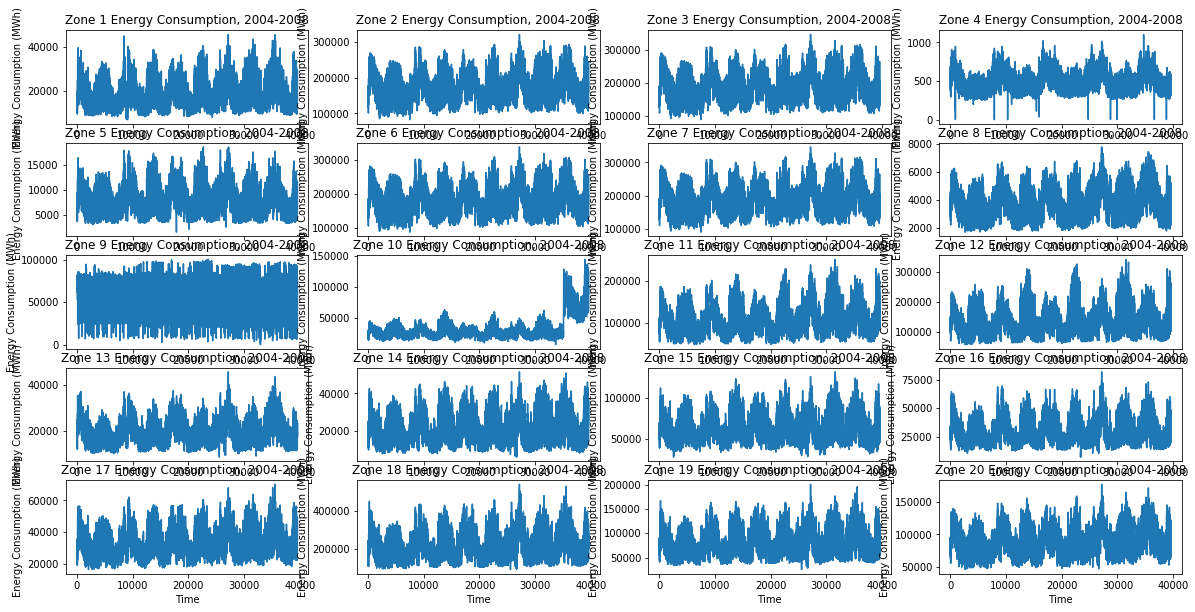

In [5]:
plt.figure(figsize = (20, 10))
for i, x in enumerate(df_zone):
    plt.subplot(5, 4, i+1)
    plt.plot(x)
    plt.xlabel("Time")
    plt.ylabel("Energy Consumption (MWh)")
    plt.title("Zone {} Energy Consumption, 2004-2008".format(i+1))
plt.show()

In [113]:
# use data for zone 1.
data = df_zone[0].reshape(-1, 1)

# normalize data with min max normalization.
normalizer = MinMaxScaler(feature_range = (0, 1))
dataset = normalizer.fit_transform(data)

# Using 80% of data for training, 20% for validation.
TRAINING_PERC = 0.80

train_size = int(len(dataset) * TRAINING_PERC)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of samples training set: " + str((len(train))))
print("Number of samples test set: " + str((len(test))))

Number of samples training set: 31660
Number of samples test set: 7916


In [7]:
# helper function to read data.
def create_dataset(dataset, window_size = 1):
    data_x, data_y = [], []
    for i in range(len(dataset) - window_size - 1):
        sample = dataset[i:(i + window_size), 0]
        data_x.append(sample)
        data_y.append(dataset[i + window_size, 0])
    return(np.array(data_x), np.array(data_y))

def create_model(train_X, train_Y, window_size = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(LSTM(5,input_shape = (1, window_size), ))
    vanilla_rnn.add(Dense(1))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam")
    
    return(vanilla_rnn)

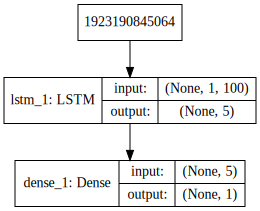

In [8]:
window_size = 100
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model(train_X, train_Y, window_size)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))

Train on 26825 samples, validate on 4734 samples
Epoch 1/100
 - 2s - loss: 5.2102e-04 - val_loss: 6.6135e-04
Epoch 2/100
 - 2s - loss: 4.8219e-04 - val_loss: 5.8383e-04
Epoch 3/100
 - 2s - loss: 4.4472e-04 - val_loss: 5.1107e-04
Epoch 4/100
 - 2s - loss: 4.1918e-04 - val_loss: 4.9599e-04
Epoch 5/100
 - 2s - loss: 3.9829e-04 - val_loss: 5.1296e-04
Epoch 6/100
 - 2s - loss: 3.7026e-04 - val_loss: 4.5757e-04
Epoch 7/100
 - 2s - loss: 3.5889e-04 - val_loss: 3.9208e-04
Epoch 8/100
 - 2s - loss: 3.5078e-04 - val_loss: 3.8380e-04
Epoch 9/100
 - 2s - loss: 3.2859e-04 - val_loss: 3.8915e-04
Epoch 10/100
 - 2s - loss: 3.2391e-04 - val_loss: 3.8493e-04
Epoch 11/100
 - 2s - loss: 3.1838e-04 - val_loss: 3.5264e-04
Epoch 12/100
 - 2s - loss: 3.0682e-04 - val_loss: 3.6476e-04
Epoch 13/100
 - 2s - loss: 2.9878e-04 - val_loss: 3.7396e-04
Epoch 14/100
 - 3s - loss: 2.9643e-04 - val_loss: 4.9982e-04
Epoch 15/100
 - 2s - loss: 2.8720e-04 - val_loss: 3.8915e-04
Epoch 16/100
 - 2s - loss: 2.8394e-04 - val_l

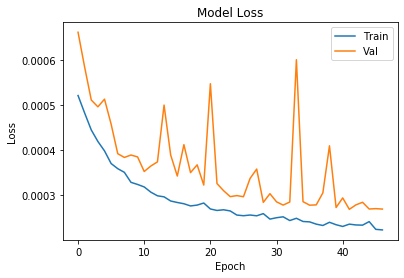

In [16]:
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, callbacks=[es])
plot_history(history)

In [17]:
def get_predict_and_score(model, X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability.
    orig_data =normalizer.inverse_transform([Y])
    # calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

def get_naive_hour_predict_and_score(X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(np.hstack((Y[0], Y[0:-1])).reshape(-1, 1))
    # transform also the label to the original scale for interpretability.
    orig_data =normalizer.inverse_transform([Y])
    # calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

def get_naive_day_predict_and_score(X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(np.hstack((Y[0:24], Y[0:-24])).reshape(-1, 1))
    # transform also the label to the original scale for interpretability.
    orig_data =normalizer.inverse_transform([Y])
    # calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

def get_naive_week_predict_and_score(X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(np.hstack((Y[0:24*7], Y[0:-24*7])).reshape(-1, 1))
    # transform also the label to the original scale for interpretability.
    orig_data =normalizer.inverse_transform([Y])
    # calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

mse_train, train_predict = get_predict_and_score(vanilla_rnn, train_X, train_Y)
mse_test, test_predict = get_predict_and_score(vanilla_rnn, test_X, test_Y)
mse_train_naive_hour, train_predict_naive_hour = get_naive_hour_predict_and_score(train_X, train_Y)
mse_test_naive_hour, test_predict_naive_hour = get_naive_hour_predict_and_score(test_X, test_Y)
mse_train_naive_day, train_predict_naive_day = get_naive_day_predict_and_score(train_X, train_Y)
mse_test_naive_day, test_predict_naive_day = get_naive_day_predict_and_score(test_X, test_Y)
mse_train_naive_week, train_predict_naive_week = get_naive_week_predict_and_score(train_X, train_Y)
mse_test_naive_week, test_predict_naive_week = get_naive_week_predict_and_score(test_X, test_Y)

print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("(Naive -1 hour) Training data error: %.2f MSE" % mse_train_naive_hour)
print("(Naive -1 hour) Test data error: %.2f MSE" % mse_test_naive_hour)
print("(Naive -1 day) Training data error: %.2f MSE" % mse_train_naive_day)
print("(Naive -1 day) Test data error: %.2f MSE" % mse_test_naive_day)
print("(Naive -1 week) Training data error: %.2f MSE" % mse_train_naive_week)
print("(Naive -1 week) Test data error: %.2f MSE" % mse_test_naive_week)

Training data error: 562.88 MSE
Test data error: 604.24 MSE
(Naive -1 hour) Training data error: 1445.17 MSE
(Naive -1 hour) Test data error: 1493.20 MSE
(Naive -1 day) Training data error: 3022.67 MSE
(Naive -1 day) Test data error: 3284.73 MSE
(Naive -1 week) Training data error: 4528.71 MSE
(Naive -1 week) Test data error: 5281.45 MSE


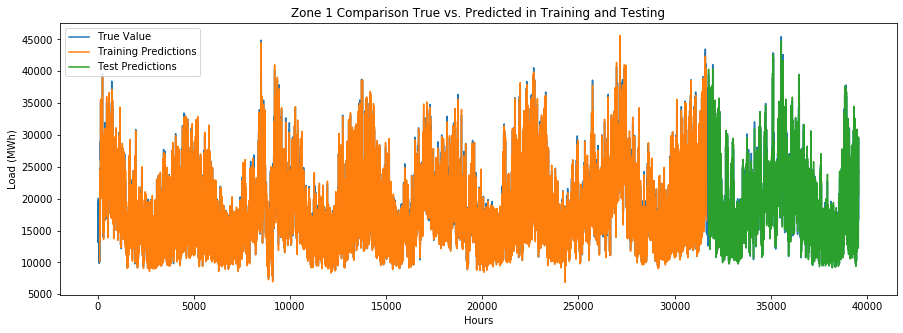

In [21]:
# Training predictions.
train_predictions = np.empty_like(dataset)
train_predictions[:, :] = np.nan
train_predictions[window_size:len(train_predict) + window_size, :] = train_predict

# Test predictions.
test_predictions = np.empty_like(dataset)
test_predictions[:, :] = np.nan
test_predictions[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(normalizer.inverse_transform(dataset), label = "True Value")
plt.plot(train_predictions, label = "Training Predictions")
plt.plot(test_predictions, label = "Test Predictions")
plt.xlabel("Hours")
plt.ylabel("Load (MWh)")
plt.title("Zone 1 Comparison True vs. Predicted in Training and Testing")
plt.legend()
plt.show()

## Multivariate RNN

In [9]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

    if single_step:
        labels.append(target[i+target_size])
    else:
        labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [105]:
PATH = r"../../Data/temperature_history.csv"
df_T = pd.read_csv(PATH)
h_df_T = df_T.set_index(['station_id', 'year', 'month', 'day'])
trans_dict = {}
for i in list(h_df_T.columns):
    trans_dict[i] = int(i[1:])
h_df_T = h_df_T.rename(columns=trans_dict)
h_df_T = h_df_T.stack()
h_df_T = h_df_T.unstack(level=0)
h_df_T.columns = h_df_T.columns.get_level_values(0)
h_df_T.columns.names = [None]
h_df_T.index.names = [None, None, None, None]
h_df_T.head(2)

1     2     3     4     5     6     7     8     9     10    11
2004 1 1 1  46.0  38.0  44.0  45.0  42.0  44.0  45.0  43.0  41.0  42.0  36.0
         2  46.0  36.0  42.0  43.0  42.0  43.0  44.0  44.0  39.0  43.0  32.0

In [106]:
PATH = r"../../Data/temperature_solution.csv"
df_T_Sol = pd.read_csv(PATH)
h_df_T_Sol = df_T_Sol.set_index(['station_id', 'year', 'month', 'day', 'hour'])
h_df_T_Sol = h_df_T_Sol.drop(['datetime', 'date'], axis=1)
h_df_T_Sol = h_df_T_Sol.unstack(level=0)
h_df_T_Sol.columns = h_df_T_Sol.columns.get_level_values(1)
h_df_T_Sol.columns.names = [None]
h_df_T_Sol.index.names = [None, None, None, None]
h_df_T_Sol.head(2)

1   2   3   4   5   6   7   8   9   10  11
2008 6 30 7  75  64  73  71  73  69  70  71  68  70  64
          8  76  67  74  72  74  71  72  71  71  71  68

In [109]:
zone_T = pd.concat([h_df_T, h_df_T_Sol], axis=0, join='outer', ignore_index=False, keys=None, 
          levels=None, names=None, verify_integrity=False, copy=True)
zone_T.head(2)

1     2     3     4     5     6     7     8     9     10    11
2004 1 1 1  46.0  38.0  44.0  45.0  42.0  44.0  45.0  43.0  41.0  42.0  36.0
         2  46.0  36.0  42.0  43.0  42.0  43.0  44.0  44.0  39.0  43.0  32.0

In [ ]:
zone_T['mean'] = 

## N-day Forecasting

In [115]:
from keras.layers import Conv1D, MaxPooling1D, Flatten, TimeDistributed

# helper function to read data.
def create_dataset_nstep(dataset, window_size = 1, nstep = 1):
    data_x, data_y = [], []
    for i in range(len(dataset) - window_size - nstep - 1):
        sample = dataset[i:(i + window_size), 0]
        data_x.append(sample)
        data_y.append(dataset[(i + window_size):(i + window_size + nstep), 0])
    return(np.array(data_x), np.array(data_y))

def create_model_nstep(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(LSTM(10))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam")
    
    return(vanilla_rnn)

def create_model_nstep2(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(LSTM(10,input_shape = (1, window_size), return_sequences=True))
    vanilla_rnn.add(LSTM(10,input_shape = (1, window_size), return_sequences=True))
    vanilla_rnn.add(LSTM(10))
    vanilla_rnn.add(Dense(nstep*2))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam")

    return(vanilla_rnn)

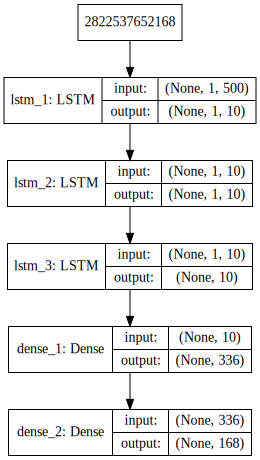

In [116]:
window_size = 500
nstep = 24*7
train_X, train_Y = create_dataset_nstep(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

multi_rnn = create_model_nstep2(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(multi_rnn, show_shapes=True).create(prog='dot', format='svg'))

In [117]:
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = multi_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, callbacks=[es])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 26342 samples, validate on 4649 samples
Epoch 1/100
 - 18s - loss: 0.0163 - val_loss: 0.0144
Epoch 2/100
 - 6s - loss: 0.0100 - val_loss: 0.0121
Epoch 3/100
 - 7s - loss: 0.0091 - val_loss: 0.0130
Epoch 4/100
 - 7s - loss: 0.0089 - val_loss: 0.0123
Epoch 5/100
 - 7s - loss: 0.0081 - val_loss: 0.0114
Epoch 6/100
 - 7s - loss: 0.0079 - val_loss: 0.0111
Epoch 7/100
 - 7s - loss: 0.0079 - val_loss: 0.0119
Epoch 8/100
 - 8s - loss: 0.0077 - val_loss: 0.0115
Epoch 9/100
 - 8s - loss: 0.0077 - val_loss: 0.0109
Epoch 10/100
 - 7s - loss: 0.0077 - val_loss: 0.0112
Epoch 11/100
 - 8s - loss: 0.0076 - val_loss: 0.0110
Epoch 12/100
 - 6s - loss: 0.0076 - val_loss: 0.0109
Epoch 13/100
 - 7s - loss: 0.0076 - val_loss: 0.0112
Epoch 14/100
 - 8s - loss: 0.0075 - val_loss: 0.0114
Epoch 00014: early stopping


In [136]:
import pdb
def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    return(score, pred)

def get_naive_week_predict_and_score_multi(X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(np.vstack((Y[0:24*7], Y[0:-24*7])))
    # transform also the label to the original scale for interpretability.
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data, pred))
    return(score, pred)

def get_naive_day_predict_and_score_multi(X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(np.vstack((Y[0:24], Y[0:-24])))
    # transform also the label to the original scale for interpretability.
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data, pred))
    return(score, pred)

def get_naive_hour_predict_and_score_multi(X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(np.vstack((Y[0, :].reshape(1, -1), Y[0:-1])))
    # transform also the label to the original scale for interpretability.
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data, pred))
    return(score, pred)

mse_train, train_predict = get_predict_and_score_multi(multi_rnn, train_X, train_Y)
mse_test, test_predict = get_predict_and_score_multi(multi_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
mse_train_naive_week, train_predict_naive_week = get_naive_week_predict_and_score_multi(train_X, train_Y)
mse_test_naive_week, test_predict_naive_week = get_naive_week_predict_and_score_multi(test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train_naive_week)
print("Test data error: %.2f MSE" % mse_test_naive_week)

Training data error: 3421.49 MSE
Test data error: 4303.71 MSE
Training data error: 4491.11 MSE
Test data error: 5355.63 MSE


(7247, 168)


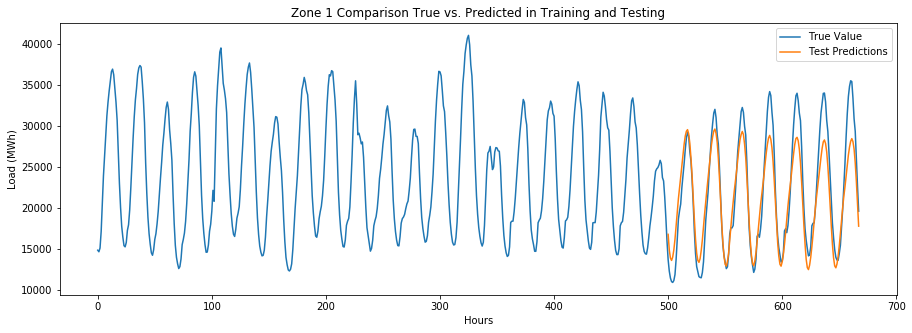

In [157]:
# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(normalizer.inverse_transform(dataset)[train_size:train_size + window_size + nstep], label = "True Value")
# plt.plot(train_predictions, label = "Training Predictions")
plt.plot(np.concatenate((np.array([np.nan] * window_size)  , test_predict[0])), label = "Test Predictions")
plt.xlabel("Hours")
plt.ylabel("Load (MWh)")
plt.title("Zone 1 Comparison True vs. Predicted in Training and Testing")
plt.legend()
plt.show()